# Tutorial 3: Stereo-seq mouse olfactory bulb datasets

## 1 Import modules

In [1]:
import pandas as pd
import scanpy as sc
import Castl

## 2 Load data and genelist

In [2]:
adata = sc.read_h5ad("../data/Stereoseq/SSMOB_raw_no_mito.h5ad")
adata.var_names_make_unique()
adata.obs["x_pixel"] = pd.Series(adata.obsm['spatial'][:, 1], index=adata.obs.index)
adata.obs["y_pixel"] = pd.Series(adata.obsm['spatial'][:, 0], index=adata.obs.index)
sc.pp.log1p(adata)

In [3]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/Stereoseq/SSMOB_{method}_results_processed.csv'
    var_name = f'{method}_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

In [4]:
methods = ['spatialde', 'spark', 'sparkx', 'somde', 'spagcn', 'spanve', 'heartsvg']
gene_lists = {}

for method in methods:
    file_path = f'../results/Stereoseq/Stereoseq_stabl/SSMOB_{method}_stabl_processed.csv'
    var_name = f'{method}_combined_genelist'
    gene_lists[var_name] = pd.read_csv(file_path)

locals().update(gene_lists)

## 3 Run Castl

### 3.1 Rank aggregation

gene     score  rank  pred
10023  Gabra1  148412.0     1     1
17189   Meis2  148303.0     2     1
23394   Ndrg4  148032.0     3     1
3116     Ncdn  147855.0     4     1
22262    Gad1  147766.0     5     1

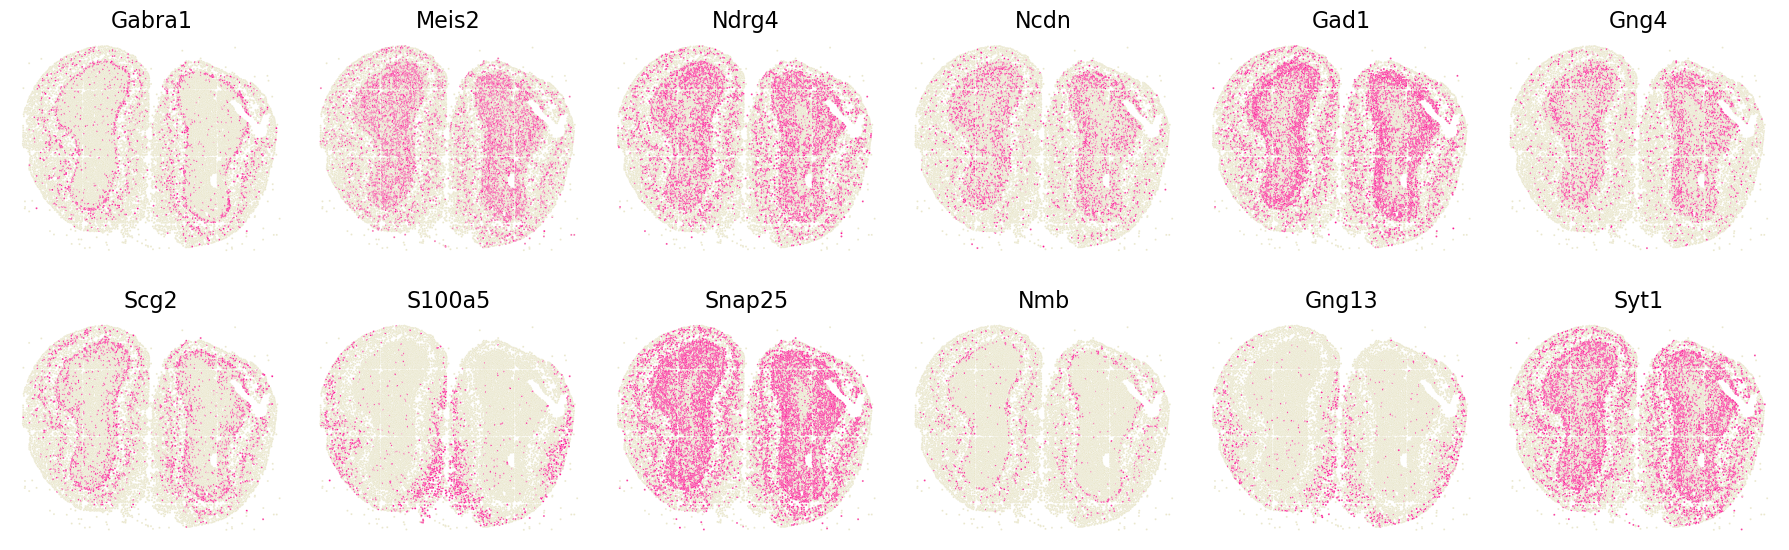

In [5]:
rank_agg_genelist = Castl.rank_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    rank_col='adjusted_p_value',
    ascending=True,
    top_percent=0.1
)

Castl.plot_gene(
    adata=adata,
    gene_df=rank_agg_genelist,
    gene_col='gene',
    sort_col='score',
    ascending=False,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6),
)

rank_agg_genelist.head()

### 3.2 P-value aggregation

gene  combined_p_value  adjusted_p_value  rank  pred
13305    Tenm3               0.0               0.0     1     1
8490    Pcp4l1               0.0               0.0     2     1
4872   Camk2n1               0.0               0.0     3     1
25873    Itm2b               0.0               0.0     4     1
4870    Kctd12               0.0               0.0     5     1

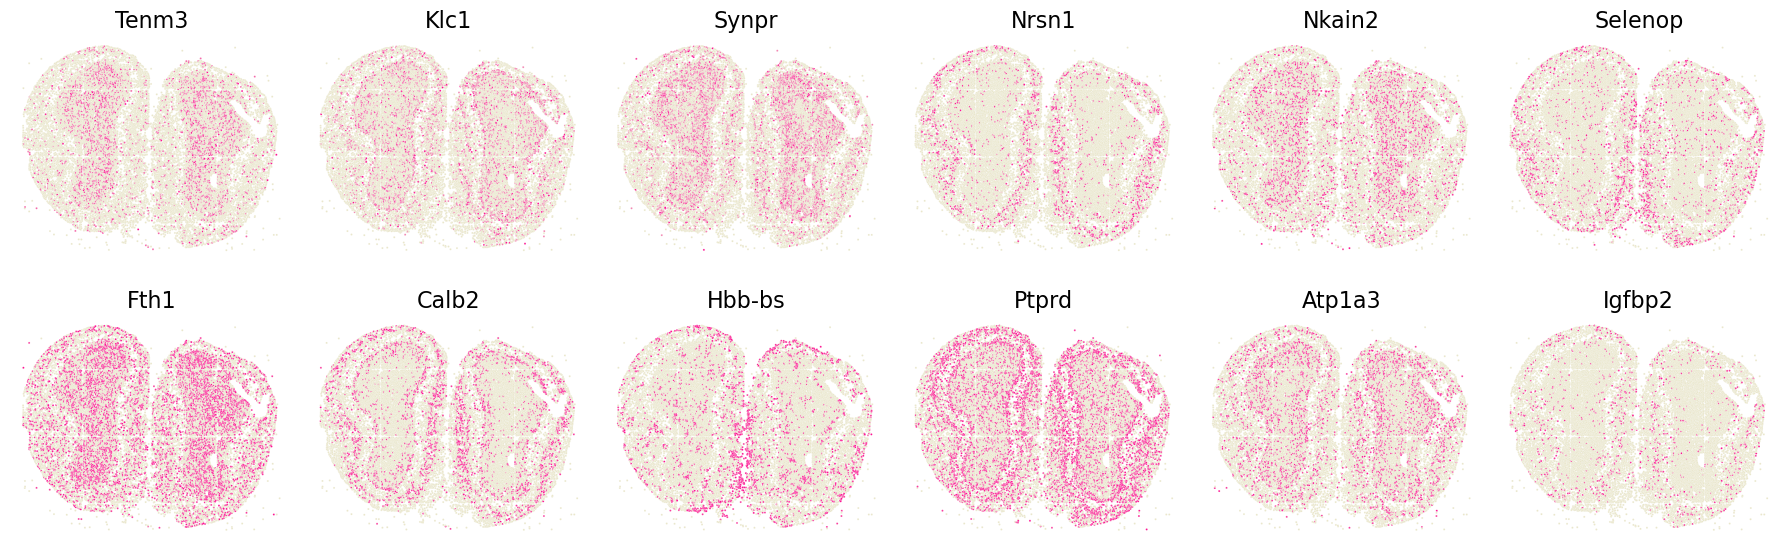

In [6]:
pval_agg_genelist = Castl.pval_agg(
    gene_list=[spatialde_genelist, spark_genelist, sparkx_genelist, 
               somde_genelist, spagcn_genelist, spanve_genelist, heartsvg_genelist],
    gene_col='gene',
    pvalue_col='adjusted_p_value',
    correction='fdr_by'
)

Castl.plot_gene(
    adata=adata,
    gene_df=pval_agg_genelist,
    gene_col='gene',
    sort_col='adjusted_p_value',
    ascending=True,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6)
)

pval_agg_genelist.head()

### 3.1 Stabl aggregation

Optimal threshold: 0.293
Total SVGs selected: 660
ArtGene count in selection: 0
Non-ArtGene count in selection: 660


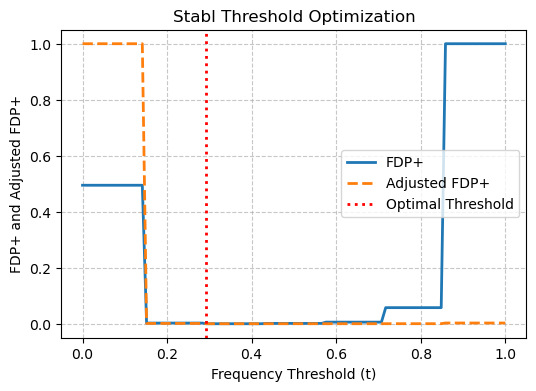

gene  frequency  rank  pred
15027  Calm2   0.857143     1     1
24580  Tshz1   0.857143     2     1
13548   Pcp4   0.857143     3     1
41341  Cdhr1   0.857143     4     1
39137   Scg2   0.857143     5     1

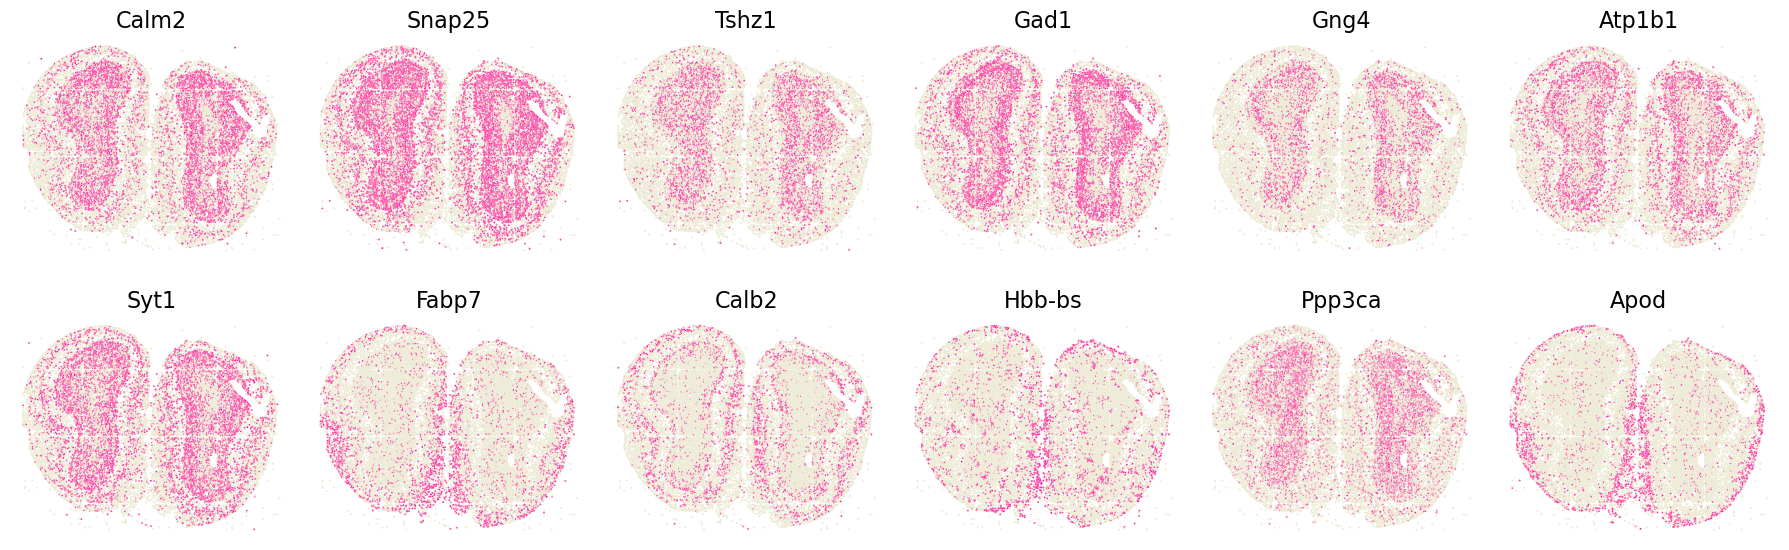

In [7]:
stabl_agg_genelist = Castl.stabl_agg(
    gene_list=[spatialde_combined_genelist, spark_combined_genelist, sparkx_combined_genelist, 
               somde_combined_genelist, spagcn_combined_genelist, spanve_combined_genelist, heartsvg_combined_genelist],
    gene_col = 'gene',
    pred_col = 'pred',
    penalty_factor=0.1,
    plot=True
)

Castl.plot_gene(
    adata=adata,
    gene_df=stabl_agg_genelist,
    gene_col='gene',
    sort_col='frequency',
    ascending=False,
    cmap='white_pink',
    top_n=12,
    spotsize=2,
    figsize=(18, 6)
)

stabl_agg_genelist.head()

## 4 Tissue enrichment analysis

In [8]:
%load_ext rpy2.ipython

D:\Apps\Anaconda3\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [9]:
%R -i stabl_agg_genelist

R[write to console]: 

R[write to console]: 

R[write to console]: castlRUtils package loaded.
Required packages are now available:
- Core packages: dplyr, ggplot2
- Analysis packages: clusterProfiler, org.Hs.eg.db, patchwork, TissueEnrich, SummarizedExperiment
All dependencies are ready to use.

R[write to console]: No background list provided. Using all the
                genes as background.



                Log10PValue Tissue.Specific.Genes fold.change samples
Adipose Tissue    0.6492726                    10   1.9601917       5
Adrenal Gland     6.7698512                    29   3.3695784       3
Appendix          0.0000000                     1   0.2213665       3
Bone Marrow       0.0000000                     3   0.4279752       4
Breast            0.0000000                     4   1.1943493       4
Cerebral Cortex  92.5797119                   233   4.3993331       3
                         Tissue
Adipose Tissue   Adipose Tissue
Adrenal Gland     Adrenal Gland
Appendix               Appendix
Bone Marrow         Bone Marrow
Breast                   Breast
Cerebral Cortex Cerebral Cortex
[1] "Cerebral Cortex" "Adrenal Gland"   "Ovary"           "Heart Muscle"   
[5] "Adipose Tissue"  "Seminal Vesicle" "Cervix, uterine" "Prostate"       


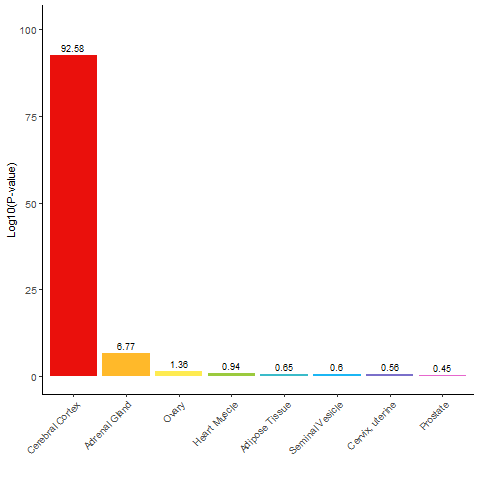

In [10]:
%%R
library(castlRUtils)

tea_results <- perform_tea(
  gene_list = stabl_agg_genelist,
  organism = "Mus Musculus",
  top_n = 8
)

print(head(tea_results$enrichment_results))
print(tea_results$top_tissues)

print(tea_results$plot)